In [1]:
import numpy as np
import splat
import wisps
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import wisps.simulations as wispsim

In [3]:
from astropy.coordinates import SkyCoord

In [4]:
J1_NIPS=24 #limiting mag in NISP
J2_NIPS=27 #best case scenario

In [20]:
def get_abs_mag(spt):
    #magnitude from spt and relation
    j, h=wisps.absolute_magnitude_jh(spt)
    return h

In [6]:
spgrid=wispsim.SPGRID

In [7]:
abs_mags=np.array([get_abs_mag(s ) for s in spgrid])

In [21]:
dmaxs1=wisps.get_distance(abs_mags, np.ones_like(abs_mags)*J1_NIPS)
dmaxs2=wisps.get_distance(abs_mags, np.ones_like(abs_mags)*J2_NIPS)

In [22]:
dmaxs1

array([5896.57735146, 4875.28490103, 4403.52027203, 3890.45144994,
       3404.08189701, 3206.26932451, 2594.17936212, 2477.42205763,
       2023.01917868, 1651.96179823, 1419.05752169, 1361.44468247,
       1336.59551655, 1294.19584145, 1288.24955169, 1282.33058266,
       1111.73172728,  862.97854777,  685.48822645,  498.88448746,
        442.58837236,  362.02575879,  189.7168681 ,   45.29055407,
         17.15480183])

In [9]:
import astropy.units as u

In [23]:
EDFS=SkyCoord(l=24.6*u.deg, b=-82.0*u.deg , frame='galactic').galactic
EDF_CH=SkyCoord("3:32:28.0 -27:48:30" , obstime="J2000", unit=u.deg).galactic

In [24]:
#compute volume correction terms 
EDFS_vcs1=np.array([ wispsim.custom_volume(EDFS.l.radian,EDFS.b.radian, 1., dm, 300.) for dm in dmaxs1])
EDF_CH_vcs1=np.array([ wispsim.custom_volume(EDF_CH.l.radian, EDFS.b.radian,1, dm, 300.) for dm in dmaxs1])

EDFS_vcs2=np.array([ wispsim.custom_volume(EDFS.l.radian,EDFS.b.radian, 1., dm, 300.) for dm in dmaxs2])
EDF_CH_vcs2=np.array([ wispsim.custom_volume(EDF_CH.l.radian, EDFS.b.radian,1, dm,  300.) for dm in dmaxs2])

In [25]:
EDFS_CH_vols1=EDF_CH_vcs1*(20*(u.deg**2)).to(u.radian**2)
EDF_vols1=EDFS_vcs1*(10*(u.deg**2)).to(u.radian**2)

EDFS_CH_vols2=EDF_CH_vcs2*(20*(u.deg**2)).to(u.radian**2)
EDF_vols2=EDFS_vcs2*(10*(u.deg**2)).to(u.radian**2)

In [13]:
wisps.absolute_magnitude_jh([20, 30])

(array([11.84, 14.21]), array([11.05, 13.44]))

In [14]:
#the empirical luminosity function
import wisps.simulations.euclid as eucl

In [39]:
def get_numbers( model, h=300, field='fornax'):
    ds=eucl.expected_numbers(model, field=field, h=h)
    simdf=pd.DataFrame.from_records(ds)
    cutdf=(simdf[simdf.h.between(0, 27)]).reset_index(drop=True)
    
    NORM = 0.63*(10**-3)/ len(cutdf.teff[np.logical_and(cutdf.teff>=1650, cutdf.teff <=1800)])
    
    NSIM=dict(zip(wispsim.SPGRID,np.zeros(len(wispsim.SPGRID))))
    #rounded spectral type
    
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        NSIM[g[0]]=np.nansum((g[1]).prob*NORM)
    return NSIM

In [40]:
%%capture
n_south_brf=get_numbers('baraffe2003', h=300, field='south')
n_south_marl=get_numbers('marley2019', h=300, field='south')
n_south_phil=get_numbers('phillips2020', h=300, field='south')
n_south_saum=get_numbers('saumon2008', h=300, field='south')

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of eff

In [41]:
%%capture
n_forn_brf=get_numbers('baraffe2003', h=300, field='fornax')
n_forn_marl=get_numbers('marley2019', h=300, field='fornax')
n_forn_phil=get_numbers('phillips2020', h=300, field='fornax')
n_forn_saum=get_numbers('saumon2008', h=300, field='fornax')

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]
The number of eff

In [42]:
import seaborn as sns
sns.set_palette('Set2')

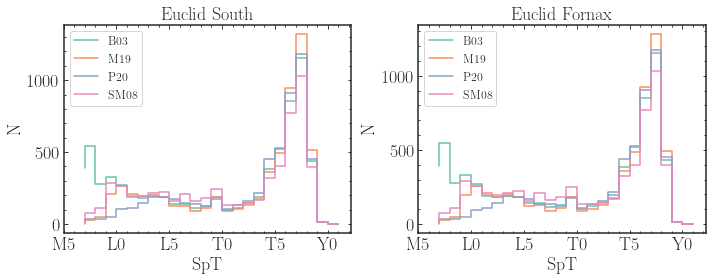

In [46]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4), sharey=False, sharex=True)


ax.step(spgrid, np.array([n_south_brf[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='B03')
ax.step(spgrid, np.array([n_south_marl[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='M19')
ax.step(spgrid, np.array([n_south_phil[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='P20')
ax.step(spgrid, np.array([n_south_saum[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='SM08')

ax1.step(spgrid, np.array([n_forn_brf[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='B03')
ax1.step(spgrid, np.array([n_forn_marl[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='M19')
ax1.step(spgrid, np.array([n_forn_phil[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='P20')
ax1.step(spgrid, np.array([n_forn_saum[k] for k in wispsim.SPGRID])*EDFS_CH_vols2, label='SM08')

ax.set_title(r'Euclid South', fontsize=18)
ax1.set_title(r'Euclid Fornax', fontsize=18)

for a in [ax, ax1]:
    a.minorticks_on()
    a.set_xlabel('SpT', fontsize=18)
    a.legend()
    #a.set_yscale('log')
    a.set_ylabel(r'N', fontsize=18)
    a.set_xticks([15, 20, 25, 30, 35, 40])
    a.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])




plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/euclid_predictions.pdf')

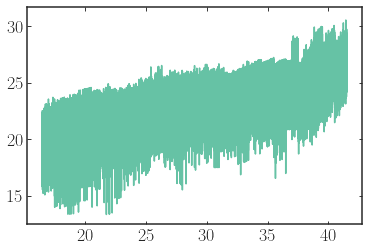

In [38]:
#plt.plot(d['spt'], d['j'], alpha=0.1)
plt.plot(d['spt'], d['h'],)